In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import collections

In [2]:
# Display directory contents
print(os.listdir("D://ClassAIML//DLWithPython//ClassNB//Projects//ClassProj1//stacksample"))

['Answers.csv', 'Questions.csv', 'Tags.csv']


In [3]:
# Load tags data
df_tags = pd.read_csv('D://ClassAIML//DLWithPython//ClassNB//Projects//ClassProj1//stacksample/Tags.csv', encoding='iso-8859-1')

In [4]:
# Plotting top 10 tags
def plot_tags(tagCount):
    x, y = zip(*tagCount)
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 0.8, 50)]   
    area = [i / 4000 for i in y]
    plt.figure(figsize=(9, 8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i, y[i], marker='o', linestyle='', ms=area[i], label=x[i])
    plt.legend(numpoints=1)
    plt.show()

[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009)]


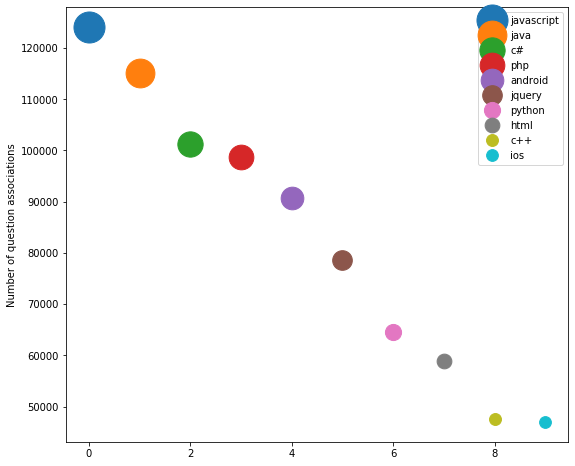

In [5]:
# Get top 10 most frequent tags
tagCount = collections.Counter(df_tags['Tag']).most_common(10)
print(tagCount)
plot_tags(tagCount)

In [6]:
# Define top 10 tags manually
top10 = ['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', 'c++', 'ios']

In [7]:
# Filter dataset for only these top 10 tags
tag_top10 = df_tags[df_tags.Tag.isin(top10)]
print(tag_top10.shape)

(826739, 2)


In [8]:
# Count the number of questions per tag
print(tag_top10['Id'].value_counts().head(10))

30798790    5
31085960    5
11648170    5
35318730    5
4009250     5
30289880    5
23267320    5
35283570    5
30991580    5
23484760    5
Name: Id, dtype: int64


In [9]:
# Function to get all tags associated with a question Id
def add_tags(question_row):
    return tag_top10[tag_top10['Id'] == question_row['Id']].Tag.values

In [10]:
id_to_tags = tag_top10.groupby('Id')['Tag'].apply(list).to_dict()
tag_top10 = tag_top10.drop_duplicates('Id').copy()
tag_top10['Tags'] = tag_top10['Id'].map(id_to_tags)

In [11]:
# Drop individual 'Tag' column as we now have combined 'Tags'
tag_top10.drop(["Tag"], axis=1, inplace=True)

In [12]:
# Drop duplicates to avoid repeat entries
tag_top10 = tag_top10.loc[tag_top10.astype(str).drop_duplicates().index]

In [13]:
# Load question text data
ques = pd.read_csv('D://ClassAIML//DLWithPython//ClassNB//Projects//ClassProj1//clean_questions.csv', encoding='iso-8859-1')
ques.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,This is something I've pseudo-solved many time...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...


In [14]:
# Merge questions and tags on Id
total = pd.merge(ques, tag_top10, on='Id')
print(total.shape)

(706336, 8)


In [15]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [16]:
# Binarize multi-label outputs
mlb = MultiLabelBinarizer()
mlb.fit(total['Tags'])
labels = mlb.classes_

In [17]:
# Using only first 100,000 samples for faster execution initially (you can scale later)
train, test = train_test_split(total[:300000], test_size=0.25, random_state=24)
# Use entire dataset
#train, test = train_test_split(total, test_size=0.25, random_state=24)

In [18]:
# Extract title, body, and labels
X_train_t = train['Title']
X_train_b = train['Body']
y_train = mlb.transform(train['Tags'])

X_test_t = test['Title']
X_test_b = test['Body']
y_test = mlb.transform(test['Tags'])

In [19]:
# ---- Tokenizing Titles ----
from nltk.tokenize import word_tokenize
#from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Input, Embedding, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.preprocessing.text import Tokenizer

C:\Users\avbor\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\avbor\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [20]:
# Compute max length for padding
sent_lens_t = X_train_t.apply(lambda x: len(word_tokenize(x)))
max_len_t = int(np.quantile(sent_lens_t, 0.97))  # Covers 97% of sentences

In [21]:
# Tokenization and sequence transformation
tok_t = Tokenizer()
tok_t.fit_on_texts(X_train_t)
vocab_len_t = len(tok_t.word_index)
seq_train_t = sequence.pad_sequences(tok_t.texts_to_sequences(X_train_t), maxlen=max_len_t)
seq_test_t = sequence.pad_sequences(tok_t.texts_to_sequences(X_test_t), maxlen=max_len_t)

In [22]:
# ---- Tokenizing Bodies ----
sent_lens_b = X_train_b.apply(lambda x: len(word_tokenize(x)))
max_len_b = int(np.quantile(sent_lens_b, 0.90))  # Covers 90% of bodies

In [23]:
tok_b = Tokenizer()
tok_b.fit_on_texts(X_train_b)
vocab_len_b = len(tok_b.word_index)
seq_train_b = sequence.pad_sequences(tok_b.texts_to_sequences(X_train_b), maxlen=max_len_b)
seq_test_b = sequence.pad_sequences(tok_b.texts_to_sequences(X_test_b), maxlen=max_len_b)

In [24]:
# ---- Model Definition ----
from keras.layers import GRU, Input, Embedding, Dense, Dropout, BatchNormalization, concatenate
from keras.models import Model

In [25]:
def RNN():
    # Title input pipeline
    input_t = Input(shape=(max_len_t,), name='title_input')
    x_t = Embedding(vocab_len_t + 1, 200, input_length=max_len_t, mask_zero=True)(input_t)
    x_t = GRU(128)(x_t)  # Reduced units to speed up training
    aux_out = Dense(10, activation='sigmoid', name='aux_output')(x_t)

    # Body input pipeline
    input_b = Input(shape=(max_len_b,), name='body_input')
    x_b = Embedding(vocab_len_b + 1, 100, input_length=max_len_b, mask_zero=True)(input_b)
    x_b = GRU(128)(x_b)

    # Combined pipeline
    x = concatenate([x_t, x_b])
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    main_out = Dense(10, activation='sigmoid', name='main_output')(x)

    return Model(inputs=[input_t, input_b], outputs=[main_out, aux_out])

In [26]:
# Compile and train model
model = RNN()
model.compile(optimizer='adam',
              loss={'main_output': 'categorical_crossentropy', 'aux_output': 'categorical_crossentropy'},
              metrics=['accuracy'])

In [27]:
# Fit model (Batch size can be reduced as needed for performance)
results = model.fit(
    {'title_input': seq_train_t, 'body_input': seq_train_b},
    {'main_output': y_train, 'aux_output': y_train},
    validation_data=(
        {'title_input': seq_test_t, 'body_input': seq_test_b},
        {'main_output': y_test, 'aux_output': y_test}
    ),
    epochs=5,
    batch_size=512  # Batch size can be reduced as needed for performance, like 512
)

Epoch 1/5
440/440 [==============================] - 5548s 13s/step - loss: 7.4555 - main_output_loss: 5.3539 - aux_output_loss: 2.1016 - main_output_accuracy: 0.2918 - aux_output_accuracy: 0.4356 - val_loss: 12.0012 - val_main_output_loss: 9.8655 - val_aux_output_loss: 2.1357 - val_main_output_accuracy: 0.2547 - val_aux_output_accuracy: 0.4384
Epoch 2/5
440/440 [==============================] - 8733s 20s/step - loss: 35.8034 - main_output_loss: 33.7009 - aux_output_loss: 2.1025 - main_output_accuracy: 0.1533 - aux_output_accuracy: 0.4213 - val_loss: 29.9143 - val_main_output_loss: 27.7758 - val_aux_output_loss: 2.1385 - val_main_output_accuracy: 0.2069 - val_aux_output_accuracy: 0.4023
Epoch 3/5
440/440 [==============================] - 5598s 13s/step - loss: 101.3555 - main_output_loss: 99.2140 - aux_output_loss: 2.1415 - main_output_accuracy: 0.1260 - aux_output_accuracy: 0.4124 - val_loss: 106.2619 - val_main_output_loss: 104.1324 - val_aux_output_loss: 2.1295 - val_main_output_a

In [28]:
# Evaluate performance
pred_main, pred_aux = model.predict({'title_input': seq_test_t, 'body_input': seq_test_b}, verbose=1)

2344/2344 [==============================] - 336s 142ms/step


In [29]:
from sklearn.metrics import classification_report, f1_score

In [30]:
# Threshold outputs to generate predictions
print("Sample-wise F1 score:", f1_score(y_test, pred_main > 0.5, average='samples'))
print(classification_report(y_test, pred_main > 0.5, target_names=labels))

Sample-wise F1 score: 0.2034163614163614
              precision    recall  f1-score   support

     android       0.12      1.00      0.22      9268
          c#       0.17      1.00      0.29     12628
         c++       0.08      1.00      0.14      5643
        html       0.07      1.00      0.13      5332
         ios       0.06      1.00      0.11      4297
        java       0.16      1.00      0.27     11744
  javascript       0.15      1.00      0.26     11108
      jquery       0.12      1.00      0.22      9267
         php       0.15      1.00      0.26     11030
      python       0.07      1.00      0.14      5579

   micro avg       0.11      1.00      0.21     85896
   macro avg       0.11      1.00      0.20     85896
weighted avg       0.13      1.00      0.22     85896
 samples avg       0.11      1.00      0.20     85896



In [31]:
model.save('./tags_stackoverflow25052025.h5')